In [725]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from alphatims import bruker

In [798]:
folder = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_27_alphadia_mDIA_synchroPasef/data_small_lib'

In [799]:
## get files in folder
files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.tsv')]

In [800]:
files

['/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_27_alphadia_mDIA_synchroPasef/data_small_lib/20230422_TIMS05_PaSk_MCT_SA_HeLa_mDIA_SyP_2scans_each150Da_S2-B6_1_1804_d0.tsv',
 '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_27_alphadia_mDIA_synchroPasef/data_small_lib/20230422_TIMS05_PaSk_MCT_SA_HeLa_mDIA_P001_diaP_pydiAID8_1300V_S2-H1_1_1835_d4_d8.tsv',
 '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_27_alphadia_mDIA_synchroPasef/data_small_lib/20230422_TIMS05_PaSk_MCT_SA_HeLa_mDIA_SyP_6dig_scans_S2-C3_1_1807_d4_d8.tsv',
 '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_27_alphadia_mDIA_synchroPasef/data_small_lib/20230422_TIMS05_PaSk_MCT_SA_HeLa_mDIA_SyP_2scans_each150Da_S2-B6_1_1804_d4_d8.tsv',
 '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_04_27_alphadia_mDIA_synchroPasef/data_small_lib/20230422_TIMS05_PaSk_MCT_SA_HeLa_m

In [ ]:
def cv(dataframe, label, column='proteins'):
    output = []
    for _, group in dataframe.groupby(column):

        if len(group) >= 3:
            output.append(
                {'precursor_idx':group[column].iloc[0],
                'mean_ms1': group['ms1'].mean(),
                'std_ms1':  group['ms1'].std(),
                }
            )

        

    mean_df = pd.DataFrame(output)
    mean_df['cv'] = mean_df['std_ms1'] / mean_df['mean_ms1']

    protein_count = dataframe.groupby('run', as_index=False)[column].nunique()

    mean = protein_count[column].mean()

    return [
        {'method': label, 'cutoff': '10%', 'precursor': np.sum(mean_df['cv'] <= 0.10)},
        {'method': label, 'cutoff': '25%', 'precursor': np.sum(mean_df['cv'] <= 0.25)},
        {'method': label, 'cutoff': '50%', 'precursor': np.sum(mean_df['cv'] <= 0.50)},
        {'method': label, 'cutoff': '100%', 'precursor': np.sum(mean_df['cv'] <= 1.00)},
        {'method': label, 'cutoff': 'mean', 'precursor': mean},

        
    ]

In [866]:
def proteins_cv(dataframe, label, column='proteins'):
    output = []
    for _, group in dataframe.groupby(column):

        if len(group) >= 3:
            output.append(
                {'precursor_idx':group[column].iloc[0],
                'mean_ms1': group['ms1'].mean(),
                'std_ms1':  group['ms1'].std(),
                'proteins': group['proteins'].iloc[0]
                }
            )

    mean_df = pd.DataFrame(output)
    mean_df['cv'] = mean_df['std_ms1'] / mean_df['mean_ms1']
    
    protein_count = dataframe.groupby('run', as_index=False).agg({'proteins': 'nunique', 'precursor_idx': 'nunique'})

    return [
        {'method': label, 'cutoff': '10%', 'precursor': np.sum(mean_df['cv'] <= 0.10), 'proteins': mean_df[mean_df['cv'] <= 0.1 ]['proteins'].nunique()},
        {'method': label, 'cutoff': '25%', 'precursor': np.sum(mean_df['cv'] <= 0.25), 'proteins': mean_df[mean_df['cv'] <= 0.25 ]['proteins'].nunique()},
        {'method': label, 'cutoff': '50%', 'precursor': np.sum(mean_df['cv'] <= 0.50), 'proteins': mean_df[mean_df['cv'] <= 0.5 ]['proteins'].nunique()},
        {'method': label, 'cutoff': '100%', 'precursor': np.sum(mean_df['cv'] <= 1.00), 'proteins': mean_df[mean_df['cv'] <= 1. ]['proteins'].nunique()},
        {'method': label, 'cutoff': 'mean', 'precursor': protein_count[column].mean(), 'proteins': protein_count['proteins'].mean()},

        
    ]

In [1009]:
summary_df = [] 
method_list = []

for method_label, method in [
    ('diaPASEF 8S', 'diaP'),
    ('synchroPASEF 8S', '8dig'),
    ('synchroPASEF 6S', '8dig'),
    ('synchroPASEF 5S', '5dig'),
    ('synchroPASEF 4S', '4dig'),
    ('synchroPASEF 2S', '2scans')
]:
    df_list = []
    i = 0

    channel = 'd4_d8'

    for file in files:
        if method in file and channel in file:

            df = pd.read_csv(file, sep='\t')
            
            df = df[df['channel'] == 8]
            #df = df.groupby(['proteins'], as_index=False)['weighted_ms1_intensity'].mean().reset_index()
            df['run'] = f'run_{i}'
            df = df[df['weighted_ms1_height'] > 0]
            df['ms1'] = df['weighted_ms1_height'] / df['weighted_ms1_height'].median()
            
            df_list.append(df)
            i += 1

    d4 = pd.concat(df_list)
    d4['method'] = method_label
    method_list.append(d4)
    summary_df += proteins_cv(d4,method_label,column='precursor_idx')

    


In [1010]:
method_df = pd.concat(method_list)

In [1020]:
summary_df = pd.DataFrame(summary_df)

In [1021]:
summary_df

,method,cutoff,precursor,proteins
0,diaPASEF 8S,10%,8829.00,2582.00
1,diaPASEF 8S,25%,12435.00,3031.00
2,diaPASEF 8S,50%,12722.00,3056.00
3,diaPASEF 8S,100%,12764.00,3058.00
4,diaPASEF 8S,mean,15351.25,3390.00
5,synchroPASEF 8S,10%,7976.00,2459.00
6,synchroPASEF 8S,25%,11806.00,2929.00
7,synchroPASEF 8S,50%,12110.00,2958.00
8,synchroPASEF 8S,100%,12159.00,2964.00
9,synchroPASEF 8S,mean,14798.25,3337.50


In [1022]:
from alphadia.extraction import plotting
import matplotlib
output_folder = '/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_05_04_channel_scoring'

/var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/ipykernel_2109/6087892.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(methods, rotation=45, ha='right')


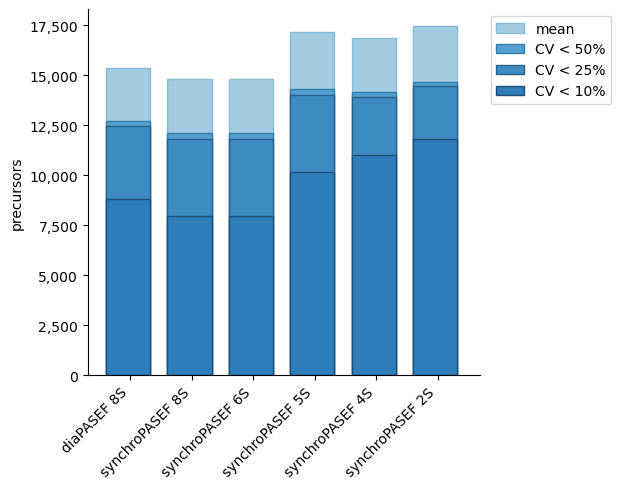

In [1023]:
import seaborn as sns
import matplotlib.pyplot as plt

methods = ['diaPASEF 8S', 'synchroPASEF 8S', 'synchroPASEF 6S', 'synchroPASEF 5S',  'synchroPASEF 4S', 'synchroPASEF 2S']

blues = np.array([ '#2d7dbb', '#3c8bc2', '#539fcd', '#a3cbe2'])[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

for cuttoff, blue in zip(['mean', '50%', '25%','10%'], blues):
    cutoff_df = summary_df[summary_df['cutoff'] == cuttoff]

    label = cuttoff if cuttoff == 'mean' else "CV < "+cuttoff

    ax.bar(cutoff_df['method'], cutoff_df['precursor'], color=blue, label=label)

#print(ax.get_xticklabels())
# rotate x labels to 45 degreees
#align right
#for ax in axs:
    
ax.set_xticklabels(methods, rotation=45, ha='right')
#ax.set_xlabel('')

# remove top and righht spine
#for ax in axs:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for patch in ax.patches:
    clr = patch.get_facecolor()
    patch.set_edgecolor(plotting.lighten_color(clr, 1.3))
    w = patch.get_width()
    patch.set_width(w*0.9)

# format y axis with thousands separator
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#plt.legend()

plt.ylabel('precursors')
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

#fig.savefig(os.path.join(output_folder, 'cv_precursors_weighted_ms1_intensity_d8.png'), dpi=300)



<AxesSubplot:>

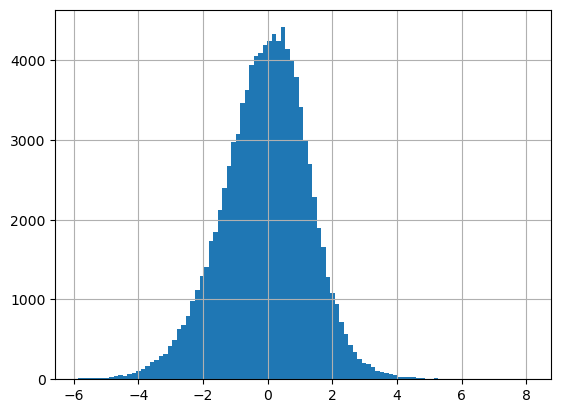

In [831]:
np.log(d4['ms1']).hist(bins=100)

In [944]:
quantile_df = []

In [948]:

for method in ['diaPASEF 8S', 'synchroPASEF 8S', 'synchroPASEF 6S', 'synchroPASEF 5S',  'synchroPASEF 4S', 'synchroPASEF 2S']:
    current_df = method_df[method_df['method'] == method]

    for _, group in current_df.groupby(['run']):
        quantile_df.append(
            {
                'method': method,
                'run': group['run'].iloc[0],
                'quantile': np.diff(np.log10(group['ms1'].quantile([0.005,0.9995]).values))[0],
                'label': r'$log_{10}$ isotope weighted MS1 height'
            }
        )





/var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/ipykernel_2109/2214053037.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in current_df.groupby(['run']):
/var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/ipykernel_2109/2214053037.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in current_df.groupby(['run']):
/var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/ipykernel_2109/2214053037.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for 

In [949]:
quantile_df = pd.DataFrame(quantile_df)

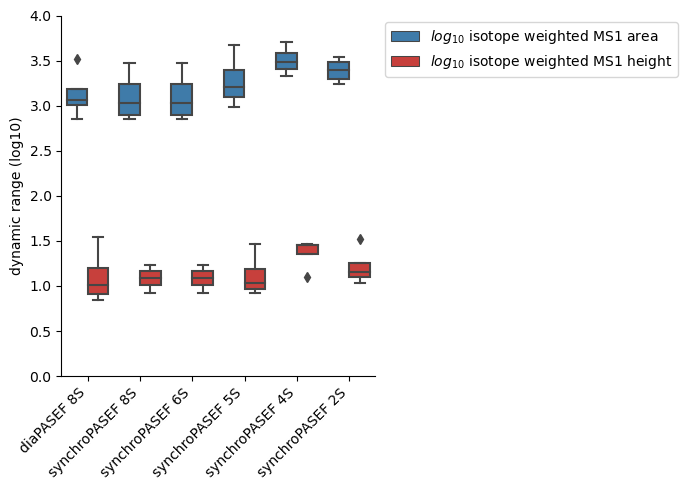

In [998]:
fig, ax = plt.subplots(figsize=(7,5))

blues = ['#084285', '#2d7dbb', '#3c8bc2', '#539fcd', '#a3cbe2'] 
reds = ['#7d040f','#de2a25', '#e66a6a', '#e98a8a', '#fcd5c2']

palette= [blues[1], reds[1]]
sns.boxplot(data=quantile_df, x='method', y='quantile', hue='label', ax=ax,palette=palette,medianprops={'label': '_median_'})
ax.set_ylim((0,4))

ax.set_xlabel('')
ax.set_ylabel('dynamic range (log10)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

fig.tight_layout()
fig.savefig(os.path.join(output_folder, 'dynamic_range_d8.png'), dpi=300)
    

In [939]:
[line.get_label() for line in ax.get_lines()]

['_child2',
 '_child3',
 '_child4',
 '_child5',
 '_median_',
 '_child7',
 '_child10',
 '_child11',
 '_child12',
 '_child13',
 '_median_',
 '_child15',
 '_child17',
 '_child18',
 '_child19',
 '_child20',
 '_median_',
 '_child22',
 '_child24',
 '_child25',
 '_child26',
 '_child27',
 '_median_',
 '_child29',
 '_child31',
 '_child32',
 '_child33',
 '_child34',
 '_median_',
 '_child36',
 '_child38',
 '_child39',
 '_child40',
 '_child41',
 '_median_',
 '_child43',
 '_child45',
 '_child46',
 '_child47',
 '_child48',
 '_median_',
 '_child50',
 '_child52',
 '_child53',
 '_child54',
 '_child55',
 '_median_',
 '_child57',
 '_child59',
 '_child60',
 '_child61',
 '_child62',
 '_median_',
 '_child64',
 '_child66',
 '_child67',
 '_child68',
 '_child69',
 '_median_',
 '_child71',
 '_child73',
 '_child74',
 '_child75',
 '_child76',
 '_median_',
 '_child78',
 '_child80',
 '_child81',
 '_child82',
 '_child83',
 '_median_',
 '_child85']

In [832]:
np.diff(np.log10(d4['ms1'].quantile([0.005,0.9995]).values))

array([3.88018547])

In [833]:
print(np.sum(mean_df['cv'] <= 0.10))
print(np.sum(mean_df['cv'] <= 0.20))
print(np.sum(mean_df['cv'] <= 0.50))
print(np.sum(mean_df['cv'] <= 1))

14466
20679
22499
22665


In [982]:
corr_list = []

In [986]:
for method in ['diaPASEF 8S', 'synchroPASEF 8S', 'synchroPASEF 6S', 'synchroPASEF 5S',  'synchroPASEF 4S', 'synchroPASEF 2S']:
    current_df = method_df[method_df['method'] == method]

    column = 'precursor_idx'
    run0_df = current_df[current_df['run'] == 'run_0'][[column, 'ms1']]
    run1_df = current_df[current_df['run'] == 'run_1'][[column, 'ms1']]
    run2_df = current_df[current_df['run'] == 'run_2'][[column, 'ms1']]
    run3_df = current_df[current_df['run'] == 'run_3'][[column, 'ms1']]

    for i, run_a in enumerate([run0_df, run1_df, run2_df, run3_df]):
        for j, run_b in enumerate([run0_df, run1_df, run2_df, run3_df]):
            if i != j:
                if i<j:
                    merged = pd.merge(run_a, run_b, on=column, how='inner')
                    corr = np.corrcoef(np.log(merged['ms1_x'].values), np.log(merged['ms1_y'].values))[0, 1]
                    corr_list.append(
                        {
                            'method': method,
                            'run_a': i,
                            'run_b': j,
                            'corr': corr,
                            'channel': 'd8'
                        }
                    )




In [987]:
corr_df = pd.DataFrame(corr_list)

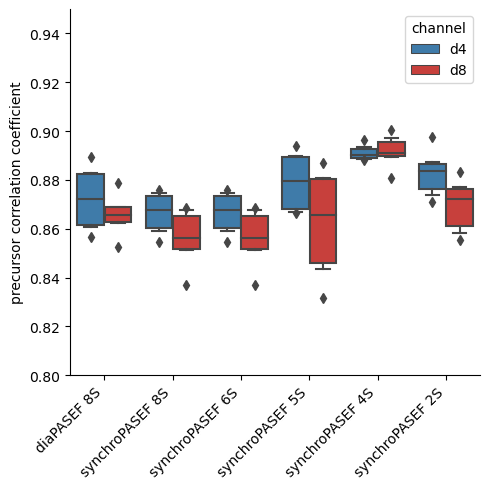

In [1017]:
fig, ax = plt.subplots(figsize=(5,5))

blues = ['#084285', '#2d7dbb', '#3c8bc2', '#539fcd', '#a3cbe2'] 

palette= [blues[1], reds[1]]
sns.boxplot(data=corr_df, x='method', y='corr',hue='channel', ax=ax, palette=palette,whis=[1, 99])
ax.set_ylim((0.8,0.95))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('precursor correlation coefficient')
ax.set_xlabel('')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig.tight_layout()
fig.savefig(os.path.join(output_folder, 'correlation_d8.png'), dpi=300)

In [1011]:
column = 'precursor_idx'

run_df = method_df[method_df['method'] == 'synchroPASEF 4S']

print(run_df['precursor_idx'].nunique())
run0_df = run_df[run_df['run'] == 'run_0'][[column, 'ms1']]
run1_df = run_df[run_df['run'] == 'run_1'][[column, 'ms1']]
run2_df = run_df[run_df['run'] == 'run_2'][[column, 'ms1']]
run3_df = run_df[run_df['run'] == 'run_3'][[column, 'ms1']]


24917


In [1012]:
for i, run_a in enumerate([run0_df, run1_df, run2_df, run3_df]):
    for j, run_b in enumerate([run0_df, run1_df, run2_df, run3_df]):
        if i != j:
            if i<j:
                merged = pd.merge(run_a, run_b, on=column, how='inner')
                corr = np.corrcoef(np.log(merged['ms1_x'].values), np.log(merged['ms1_y'].values))[0, 1]
                print(i,j,corr)

0 1 0.838038553867474
0 2 0.8468419982433553
0 3 0.8383287466233944
1 2 0.857279451398758
1 3 0.861624060529032
2 3 0.8662263318307678


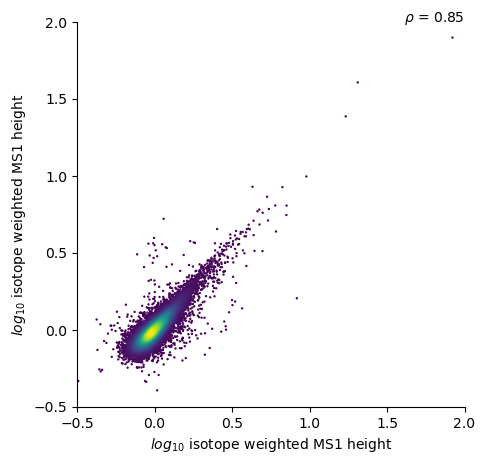

In [1018]:
merge_df = run0_df.merge(run2_df, on=column, suffixes=('_run0', '_run1'), how='inner')
merge_df['ms1_run0'] = np.log10(merge_df['ms1_run0'])
merge_df['ms1_run1'] = np.log10(merge_df['ms1_run1'])

from alphadia.extraction import calibration

fig, ax = plt.subplots(figsize=(5, 5))
calibration.density_scatter(merge_df['ms1_run0'].values, merge_df['ms1_run1'].values,axis=ax, s=0.5)
ax.set_xlim((-0.5,2))
ax.set_ylim((-0.5,2))

ax.set_xlabel(r'$log_{10}$ isotope weighted MS1 height')
ax.set_ylabel(r'$log_{10}$ isotope weighted MS1 height')

corr = np.corrcoef(merge_df['ms1_run0'].values, merge_df['ms1_run1'].values)[0,1]

ax.text(2,2,r"$\rho$" + f" = {corr:.2f}", ha='right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(os.path.join(output_folder, 'corr_precursors_weighted_ms1_height_d4.png'), dpi=300)

In [666]:
np.corrcoef(merge_df['ms1_run0'].values, merge_df['ms1_run1'].values)

array([[1.        , 0.89840501],
       [0.89840501, 1.        ]])

In [350]:
count_df = df.groupby(["run"], as_index=False).agg({'precursor_idx':'count', 'proteins':'nunique'})


(array([1.810e+02, 5.240e+02, 9.320e+02, 1.258e+03, 1.718e+03, 2.165e+03,
        2.493e+03, 2.851e+03, 3.097e+03, 2.891e+03, 2.458e+03, 2.050e+03,
        1.662e+03, 1.507e+03, 1.350e+03, 1.137e+03, 1.014e+03, 9.020e+02,
        8.440e+02, 7.290e+02, 6.650e+02, 6.340e+02, 5.510e+02, 4.860e+02,
        4.100e+02, 3.700e+02, 3.280e+02, 2.900e+02, 2.610e+02, 2.260e+02,
        2.100e+02, 1.630e+02, 1.520e+02, 1.300e+02, 1.250e+02, 1.100e+02,
        1.020e+02, 9.800e+01, 8.200e+01, 8.000e+01, 7.100e+01, 5.400e+01,
        4.800e+01, 4.400e+01, 4.700e+01, 3.300e+01, 5.100e+01, 4.400e+01,
        3.800e+01, 3.100e+01, 3.400e+01, 2.700e+01, 2.600e+01, 1.600e+01,
        3.000e+01, 1.400e+01, 1.700e+01, 1.100e+01, 1.000e+01, 1.400e+01,
        1.400e+01, 1.400e+01, 1.800e+01, 1.300e+01, 7.000e+00, 1.300e+01,
        1.900e+01, 1.100e+01, 7.000e+00, 1.400e+01, 9.000e+00, 4.000e+00,
        1.300e+01, 7.000e+00, 8.000e+00, 5.000e+00, 4.000e+00, 9.000e+00,
        3.000e+00, 8.000e+00, 7.000e+0

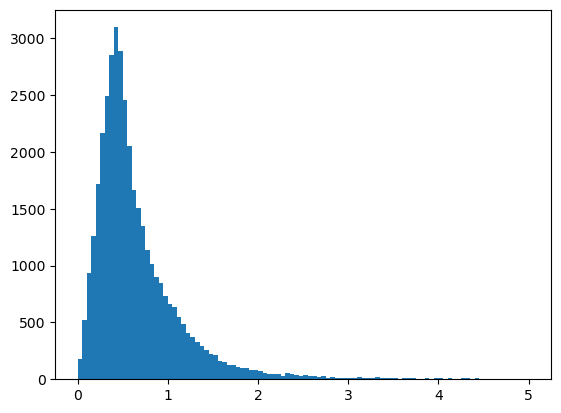

In [35]:
syp2_df = pd.read_csv("/Users/georgwallmann/Documents/data/alphadia_benchmarking/raw_data/2023_04_27_synchroPasef_mDIA/8SyP/alpha_psms.tsv", sep="\t")
diap_df = pd.read_csv("/Users/georgwallmann/Documents/data/alphadia_benchmarking/raw_data/2023_04_27_synchroPasef_mDIA/diaPASEF/alpha_psms.tsv", sep="\t")

syp2_df['intensity'] = np.power(10,syp2_df['sum_b_ion_intensity']) + np.power(10,syp2_df['sum_y_ion_intensity'])
diap_df['intensity'] = np.power(10,diap_df['sum_b_ion_intensity']) + np.power(10,diap_df['sum_y_ion_intensity'])

syp2_int = syp2_df.groupby('precursor_idx', as_index=False).agg({'intensity':'median'})
diap_int = diap_df.groupby('precursor_idx', as_index=False).agg({'intensity':'median'})

merged_df = syp2_int.merge(diap_int, on='precursor_idx', suffixes=['_syp2', '_diap'], how='inner')
merged_df['ratio'] = merged_df['intensity_syp2'] / merged_df['intensity_diap']

plt.hist(merged_df['ratio'], bins=100, range=(0, 5))
plt.xlabel('synchroPASEF / diaPASEF')
plt.ylabel('count')
plt.title('median ion intensity ratio, 8SyP vs 8F diaPASEF')

(array([  23.,   39.,   73.,   73.,  110.,  111.,  144.,  155.,  184.,
         229.,  238.,  250.,  277.,  305.,  354.,  370.,  411.,  495.,
         557.,  535.,  604.,  712.,  758.,  898., 1016., 1185., 1241.,
        1303., 1369., 1404., 1325., 1261., 1292., 1105., 1039., 1006.,
         881.,  838.,  737.,  629.,  635.,  573.,  582.,  442.,  464.,
         369.,  392.,  343.,  409.,  298.,  291.,  264.,  260.,  245.,
         227.,  234.,  190.,  204.,  190.,  162.,  157.,  141.,  164.,
         113.,  143.,  107.,  139.,  131.,  103.,   95.,  103.,  100.,
          78.,   97.,   85.,   75.,   81.,   80.,   75.,   65.,   73.,
          70.,   70.,   67.,   56.,   64.,   56.,   55.,   41.,   47.,
          42.,   48.,   45.,   53.,   40.,   40.,   44.,   42.,   33.,
          48.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9

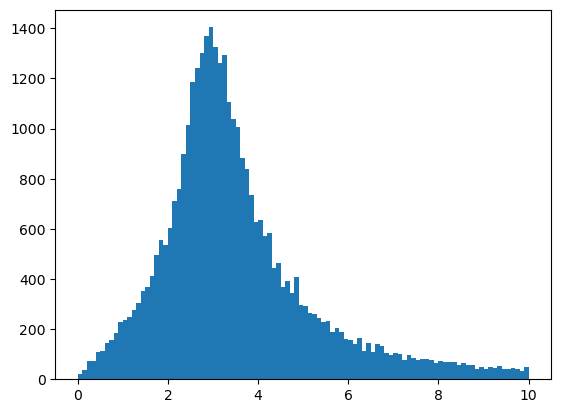

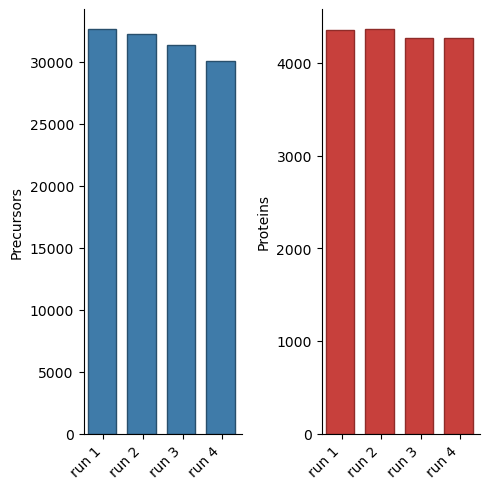

In [31]:
blues = ['#084285', '#2d7dbb', '#3c8bc2', '#539fcd', '#a3cbe2'] 
reds = ['#7d040f','#de2a25', '#e66a6a', '#e98a8a', '#fcd5c2']

fig, axs = plt.subplots(1, 2, figsize=(5, 5))

sns.barplot(count_df, x='run', y='precursor_idx', ax=axs[0], capsize=.4, linewidth=1, edgecolor=".5", errwidth=1, palette=[blues[1]])
sns.barplot(count_df, x='run', y='proteins', ax=axs[1], capsize=.4, linewidth=1, edgecolor=".5", errwidth=1, palette=[ reds[1]])

axs[0].set_ylabel('Precursors')
axs[1].set_ylabel('Proteins')

axs[0].set_xlabel('')
axs[1].set_xlabel('')

# rotate x labels to 45 degreees
#align right
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')

# remove top and righht spine
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for patch in ax.patches:
        clr = patch.get_facecolor()
        patch.set_edgecolor(lighten_color(clr, 1.3))
        w = patch.get_width()
        patch.set_width(w*0.9)

fig.tight_layout()

#fig.savefig('/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_02_13_synchroPasef_vs_diaPasef/precursors_proteins.png', dpi=300)


In [5]:
px_id = 100000/675
v11 = 456
diann = 674

v11_ids = v11*px_id
v12_ids = 77018
diann_ids = diann*px_id

print(v11_ids)
print(diann_ids)


67555.55555555556
99851.85185185185


In [7]:
diann_p = 814
px_p = 8000/833
v11_p = 741

v11_p = v11_p*px_p
diann_p = diann_p*px_p

print(v11_p)
print(diann_p)

7116.446578631452
7817.527010804321


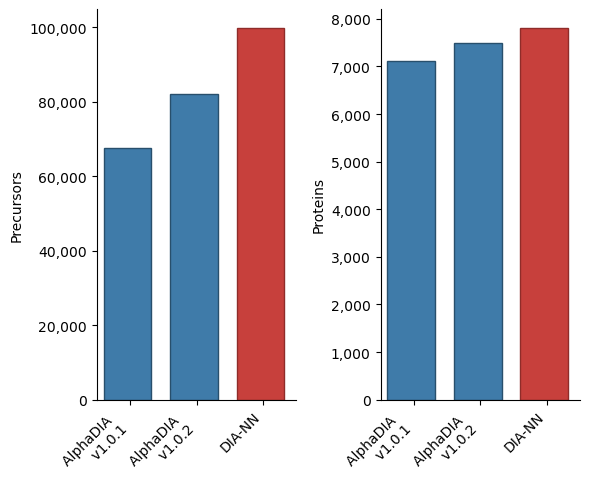

In [18]:
import matplotlib

df = pd.DataFrame([
    {'version': 'AlphaDIA \n v1.0.1', 'precursors': 67555, 'proteins': 7116},
    {'version': 'AlphaDIA \n v1.0.2', 'precursors': 82133, 'proteins': 7501},
     {'version': 'DIA-NN', 'precursors': 99851, 'proteins': 7817},
])

blues = ['#084285', '#2d7dbb', '#3c8bc2', '#539fcd', '#a3cbe2'] 
reds = ['#7d040f','#de2a25', '#e66a6a', '#e98a8a', '#fcd5c2']

fig, axs = plt.subplots(1, 2, figsize=(6, 5))

sns.barplot(df, x='version', y='precursors', ax=axs[0], capsize=.4, linewidth=1, edgecolor=".5", errwidth=1, palette=[blues[1],blues[1],reds[1]])
sns.barplot(df, x='version', y='proteins', ax=axs[1], capsize=.4, linewidth=1, edgecolor=".5", errwidth=1, palette=[blues[1],blues[1],reds[1]])

axs[0].set_ylabel('Precursors')
axs[1].set_ylabel('Proteins')

axs[0].set_xlabel('')
axs[1].set_xlabel('')

# rotate x labels to 45 degreees
#align right
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')

# remove top and righht spine
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for patch in ax.patches:
        clr = patch.get_facecolor()
        patch.set_edgecolor(lighten_color(clr, 1.3))
        w = patch.get_width()
        patch.set_width(w*0.9)

    # format y axis with thousands separator
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    

fig.tight_layout()

fig.savefig('/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_03_10_alphaDIA_whole_proteome/v1.0.2.png', dpi=300)


In [13]:
dia_pasef_data = bruker.TimsTOF('/Users/georgwallmann/Documents/data/alphadia_benchmarking/raw_data/2023_03_02_MCT_scp_hela/20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_AID8_01_S4-E8_1_644.d')
synchro_pasef_data = bruker.TimsTOF('/Users/georgwallmann/Documents/data/alphadia_benchmarking/raw_data/2023_03_02_MCT_scp_hela/20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5-25wo_01_S4-E2_1_636.d')

 52%|█████▏    | 9060/17439 [00:03<00:02, 2958.36it/s]


KeyboardInterrupt: 

Text(0.5, 0, 'precursor mz')

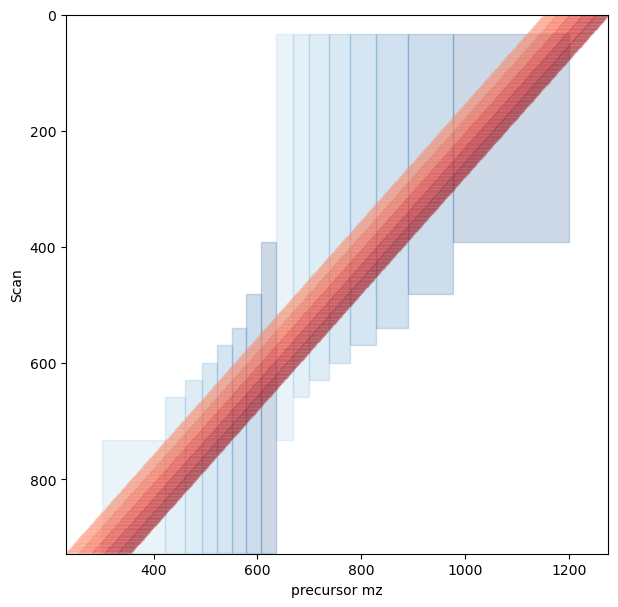

In [14]:
from alphadia.extraction import plotting
fig, ax = plt.subplots(figsize=(7,7))

plotting.plot_dia_cycle(dia_pasef_data.cycle, ax=ax, cmap_name='Blues', alpha=0.2, )
plotting.plot_dia_cycle(synchro_pasef_data.cycle, ax=ax, cmap_name='Reds', alpha=0.2, )

ax.set_xlabel('precursor mz')

#plt.savefig('/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_02_13_synchroPasef_vs_diaPasef/cycle_overlay.png')


In [10]:
from alphadia.extraction.calibration import density_scatter

In [11]:
run_names = synchro_pasef_df['run'].unique()
run_names

array(['20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5-25wo_06_S4-F9_1_656'],
      dtype=object)

In [ ]:
plot_dia_cycle

NameError: name 'synchro_pasef_data' is not defined

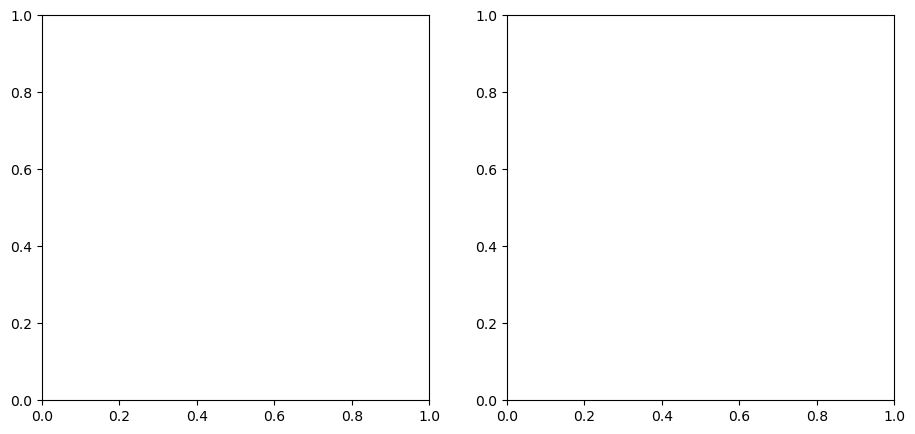

In [12]:
from alphadia.extraction import plotting


for run in synchro_pasef_df['run'].unique():
    df = synchro_pasef_df[synchro_pasef_df['run'] == run].sample(5000)
    
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))
    
    density_scatter(df['mz_observed'].values, len(synchro_pasef_data.mobility_values) - np.searchsorted(synchro_pasef_data.mobility_values[::-1],df['mobility_observed'].values), s=1, axis=axs[0])
    plotting.plot_dia_cycle(synchro_pasef_data.cycle[:,], ax=axs[0], cmap_name='Greys', alpha=0.2, )

    axs[1].scatter(df['mz_observed'].values, len(synchro_pasef_data.mobility_values) - np.searchsorted(synchro_pasef_data.mobility_values[::-1],df['mobility_observed'].values), c=df['fragment_coverage'].values*100, s=1, cmap='rainbow_r', vmin=0.0, vmax=100)
    plotting.plot_dia_cycle(synchro_pasef_data.cycle[:,], ax=axs[1], cmap_name='Greys', alpha=0.2, )
    # show color bar
    fig.colorbar(axs[0].collections[0], ax=axs[0], label='density')
    fig.colorbar(axs[1].collections[0], ax=axs[1], label='fragment coverage')


    axs[0].set_xlabel('precursor mz')
    axs[1].set_xlabel('precursor mz')

    fig.tight_layout()
    #plt.savefig(f'/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_02_13_synchroPasef_vs_diaPasef/{run}.png')
    plt.show()

for run in dia_pasef_df['run'].unique():
    df = dia_pasef_df[dia_pasef_df['run'] == run].sample(5000)

    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    density_scatter(df['mz_observed'].values, len(dia_pasef_data.mobility_values) - np.searchsorted(dia_pasef_data.mobility_values[::-1],df['mobility_observed'].values), s=1, axis=axs[0])
    plotting.plot_dia_cycle(dia_pasef_data.cycle[:,], ax=axs[0], cmap_name='Greys', alpha=0.2, )

    axs[1].scatter(df['mz_observed'].values, len(dia_pasef_data.mobility_values) - np.searchsorted(dia_pasef_data.mobility_values[::-1],df['mobility_observed'].values), c=df['fragment_coverage'].values*100, s=1, cmap='rainbow_r', vmin=0.0, vmax=100)
    plotting.plot_dia_cycle(dia_pasef_data.cycle[:,], ax=axs[1], cmap_name='Greys', alpha=0.2, )
    # show color bar
    fig.colorbar(axs[0].collections[0], ax=axs[0], label='density')
    fig.colorbar(axs[1].collections[0], ax=axs[1], label='fragment coverage')


    axs[0].set_xlabel('precursor mz')
    axs[1].set_xlabel('precursor mz')

    fig.tight_layout()
    #plt.savefig(f'/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_02_13_synchroPasef_vs_diaPasef/{run}.png')
    plt.show()

Text(0.5, 0, 'precursor mz')

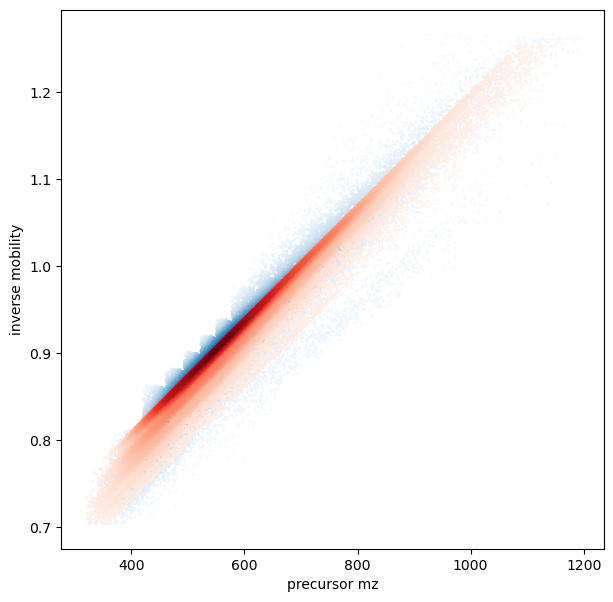

In [27]:
fig, ax = plt.subplots(figsize=(7,7))

run = dia_pasef_df['run'].unique()[0]
df = dia_pasef_df[dia_pasef_df['run'] == run]
df = df[df['qval'] < 0.01]
df = df[df['fragment_coverage'] > 0.5]
density_scatter(df['mz_observed'].values, df['mobility_observed'].values, s=1, axis=ax, cmap='Blues')

run = synchro_pasef_df['run'].unique()[0]
df = synchro_pasef_df[synchro_pasef_df['run'] == run]
df = df[df['qval'] < 0.01]
df = df[df['fragment_coverage'] > 0.5]
density_scatter(df['mz_observed'].values, df['mobility_observed'].values, s=1, axis=ax, cmap='Reds')

ax.set_ylabel('inverse mobility')
ax.set_xlabel('precursor mz')

#plt.savefig('/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_02_13_synchroPasef_vs_diaPasef/density_overlay.png')
   

Text(0.5, 0, 'precursor mz')

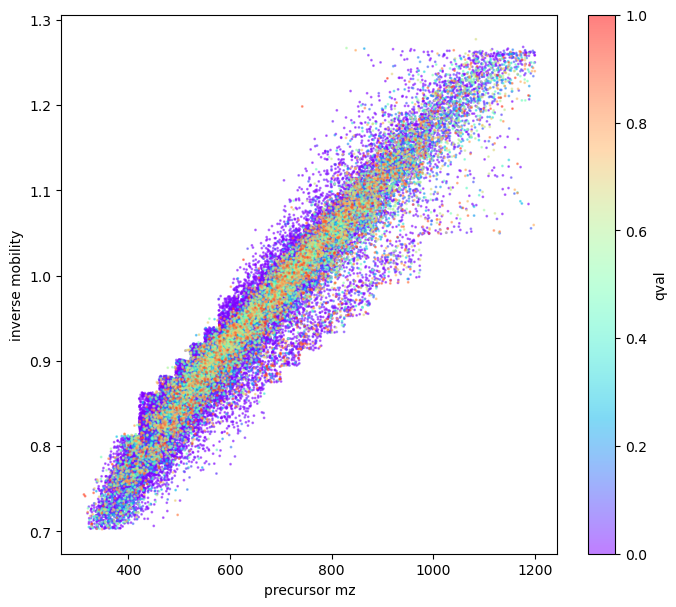

In [18]:
fig, ax = plt.subplots(figsize=(8,7))

run = dia_pasef_df['run'].unique()[0]
df = dia_pasef_df[dia_pasef_df['run'] == run]
df = df[df['decoy'] == 0]
#df = df[df['fragment_coverage'] >]

ax.scatter(df['mz_observed'].values, df['mobility_observed'].values, s=1, c=df['qval'].values, cmap='rainbow', alpha=0.5, vmin=0.0, vmax=1)
fig.colorbar(ax.collections[0], ax=ax, label='qval')

ax.set_ylabel('inverse mobility')
ax.set_xlabel('precursor mz')

#plt.savefig('/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_02_13_synchroPasef_vs_diaPasef/qval_dist_diaPASEF.png')

Text(0.5, 0, 'precursor mz')

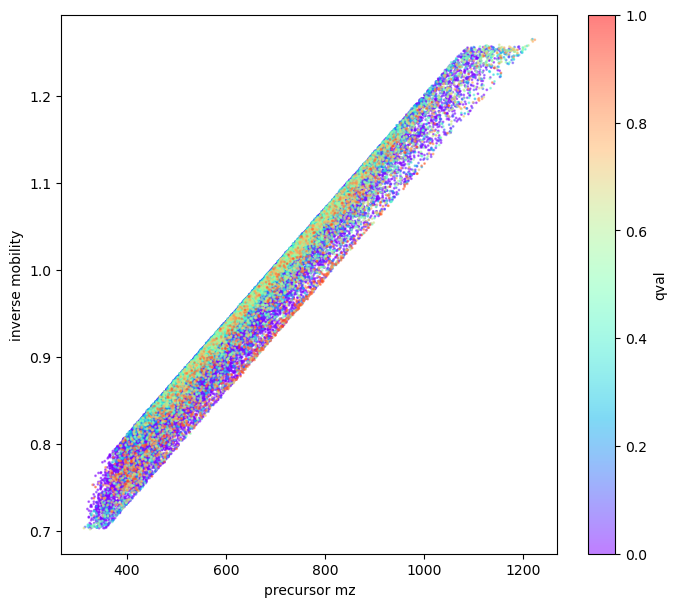

In [19]:
fig, ax = plt.subplots(figsize=(8,7))

run = synchro_pasef_df['run'].unique()[0]
df = synchro_pasef_df[synchro_pasef_df['run'] == run]
df = df[df['decoy'] == 0]

ax.scatter(df['mz_observed'].values, df['mobility_observed'].values, s=1, c=df['qval'].values, cmap='rainbow', alpha=0.5, vmin=0.0, vmax=1)
fig.colorbar(ax.collections[0], ax=ax, label='qval')

ax.set_ylabel('inverse mobility')
ax.set_xlabel('precursor mz')

#plt.savefig('/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_02_13_synchroPasef_vs_diaPasef/qval_dist_synchroPASEF.png')

In [15]:
synchro_pasef_run = synchro_pasef_df['run'].unique()[0]
df = synchro_pasef_df[synchro_pasef_df['run'] == synchro_pasef_run]
df = df[df['decoy'] == 0]
df = df[df['fragment_coverage'] > 0.25]
p_idx = df['precursor_idx'].unique()

len(p_idx)

39109

In [16]:
dia_pasef_run = dia_pasef_df['run'].unique()[0]
synchro_pasef_run = synchro_pasef_df['run'].unique()[0]

dpdf = dia_pasef_df[(dia_pasef_df['run'] == dia_pasef_run) & (dia_pasef_df['precursor_idx'].isin(p_idx))].copy()
dpdf.sort_values('qval', inplace=True)
dpdf['count'] = np.arange(len(dpdf))

#dpdf['method'] = 'dia_pasef'
spdf = synchro_pasef_df[(synchro_pasef_df['run'] == synchro_pasef_run) & (synchro_pasef_df['precursor_idx'].isin(p_idx))].copy()
spdf.sort_values('qval', inplace=True)
spdf['count'] = np.arange(len(spdf))

print(len(dpdf), len(spdf))
#spdf['method'] = 'synchro_pasef'
#combined_df = pd.concat([dpdf, spdf])

36460 39109


In [24]:
spdf

,precursor_idx,elution_group_idx,charge,precursor_mass_error,mz_library,mz_observed,precursor_isotope_correlation,sum_precursor_intensity,n_fragments_matched,n_fragments,...,rt_library,rt_calibrated,rt_error,mobility_library,mobility_calibrated,mobility_error,proba,qval,run,count
87564,3100,3100,3,-0.797088,672.693117,672.704590,0.997784,2.854323,12.0,12.0,...,1503.926249,1607.352842,-4.874205,0.988490,0.969558,0.016864,0.000352,0.000000,20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5...,0
91297,32937,32937,3,-0.804996,386.208495,386.220856,0.999912,3.514055,12.0,12.0,...,907.702168,889.334589,11.738470,0.748348,0.763825,-0.008221,0.001891,0.000000,20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5...,1
91296,30560,30560,2,1.619138,583.800611,583.814148,0.998057,3.014503,12.0,12.0,...,852.225907,819.434942,-0.028997,0.936194,0.925157,0.001782,0.001891,0.000000,20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5...,2
91295,73086,73086,3,0.694017,647.666568,647.679199,0.996083,3.160222,12.0,12.0,...,1098.064448,1146.927409,-1.527873,0.979451,0.961468,0.009437,0.001891,0.000000,20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5...,3
91294,8701,8701,2,-0.545140,832.441074,832.450928,0.995625,2.486081,11.0,12.0,...,1000.479141,1010.611023,-16.203369,1.089954,1.066158,-0.000856,0.001891,0.000000,20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169956,65957,65957,3,-6.331334,702.687203,702.694519,0.493156,2.006376,1.0,11.0,...,561.251827,466.460911,13.233211,0.957856,0.943023,0.025296,0.883872,0.922196,20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5...,42862
169961,34456,34456,3,-11.522366,408.899328,408.907379,0.963925,3.035847,7.0,12.0,...,521.354809,414.088393,-27.728774,0.735639,0.751117,0.027762,0.884172,0.922268,20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5...,42863
169964,8416,8416,2,0.909241,408.726718,408.739838,0.995858,3.409353,1.0,6.0,...,421.751193,300.114665,-5.035106,0.741679,0.757212,0.023607,0.884480,0.922293,20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5...,42864
169970,14051,14051,3,-2.826525,540.306534,540.317810,0.517621,1.836127,1.0,12.0,...,1364.296800,1503.501021,22.799394,0.795453,0.807470,0.025720,0.886710,0.922366,20230103_TIMS05_MCT_SA_HeLa_SM03p7b_Ref10_syP5...,42865


Text(0.5, 1.0, '>= 25% Coverage - Precursor IDs')

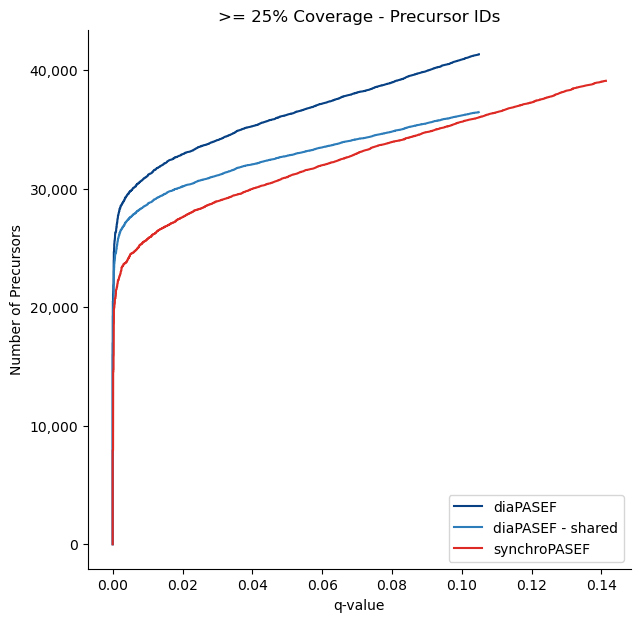

In [17]:
fig, ax = plt.subplots(figsize=(7,7))

all_dia_pasef = dia_pasef_df[(dia_pasef_df['run'] == dia_pasef_run) & (dia_pasef_df['decoy'] == 0)].copy()
all_dia_pasef.sort_values('qval', inplace=True)
all_dia_pasef['count'] = np.arange(len(all_dia_pasef))

plt.plot(all_dia_pasef['qval'].values, all_dia_pasef['count'].values, label='diaPASEF', color='#084285')
plt.plot(dpdf['qval'].values, dpdf['count'].values, label='diaPASEF - shared', color='#2d7dbb')
plt.plot(spdf['qval'].values, spdf['count'].values, label='synchroPASEF', color='#de2a25')

plt.xlabel('q-value')
plt.ylabel('Number of Precursors')

# disable top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# format y axis with thousands separator
import matplotlib.ticker
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#plt.plot([0., 1], [47000, 47000], color='black', linestyle='--', linewidth=1)
plt.legend(loc = 'lower right')

plt.title('>= 25% Coverage - Precursor IDs')
#plt.savefig('/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_02_13_synchroPasef_vs_diaPasef/precursor_ids.png')

Text(0.5, 1.0, 'Precursor IDs and Fragment Coverage')

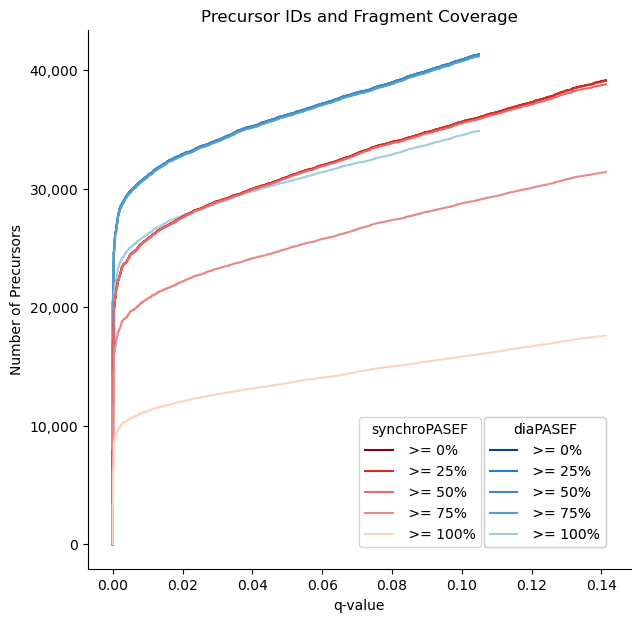

In [18]:
fig, ax = plt.subplots(figsize=(7,7))

d_legend = []

for cutoff, blue, red in zip([0, 0.25, 0.5, 0.75, 1], ['#084285', '#2d7dbb', '#3c8bc2', '#539fcd', '#a3cbe2'], ['#7d040f','#de2a25', '#e66a6a', '#e98a8a', '#fcd5c2']):
    dpdf = dia_pasef_df[(dia_pasef_df['run'] == dia_pasef_run) & (dia_pasef_df['decoy'] == 0)].copy()
    dpdf = dpdf[dpdf['fragment_coverage'] >= cutoff]
    dpdf.sort_values('qval', inplace=True)
    dpdf['count'] = np.arange(len(dpdf))

    line, = ax.plot(dpdf['qval'].values, dpdf['count'].values, label=f'>= {cutoff:.2f}', color=blue)
    
    d_legend += [line]

s_legend = []

for cutoff, blue, red in zip([0, 0.25, 0.5, 0.75, 1], ['#084285', '#2d7dbb', '#3c8bc2', '#539fcd', '#a3cbe2'], ['#7d040f','#de2a25', '#e66a6a', '#e98a8a', '#fcd5c2']):

    spdf = synchro_pasef_df[(synchro_pasef_df['run'] == synchro_pasef_run) & (synchro_pasef_df['decoy'] == 0)].copy()
    spdf = spdf[spdf['fragment_coverage'] >= cutoff]
    spdf.sort_values('qval', inplace=True)
    spdf['count'] = np.arange(len(spdf))

    line, = ax.plot(spdf['qval'].values, spdf['count'].values, label=f'>= {cutoff:.2f}', color=red)

    s_legend += [line]

legend1 = plt.legend(s_legend, [ f' >= {el}%' for el in [0, 25, 50, 75, 100]], loc=(0.50,0.04), title='synchroPASEF')
legend2 = plt.legend(d_legend, [ f' >= {el}%' for el in [0, 25, 50, 75, 100]], loc=(0.73,0.04), title='diaPASEF')

ax.add_artist(legend1)
ax.add_artist(legend2)

plt.xlabel('q-value')
plt.ylabel('Number of Precursors')

# disable top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# format y axis with thousands separator
import matplotlib.ticker
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.title('Precursor IDs and Fragment Coverage')
#plt.savefig('/Users/georgwallmann/Library/CloudStorage/OneDrive-Personal/Studium/MPI/AG Mann/alphaDIA/2023_02_13_synchroPasef_vs_diaPasef/precursor_ids_fragment_coverage.png')


In [271]:
dia

NameError: name 'dia' is not defined

In [59]:
df['mobility_observed'].values

array([0.96314657, 1.15129316, 1.11314654, ..., 0.96896553, 0.88362068,
       0.95409483])

In [92]:
synchro_pasef_data.mobility_values

array([1.3       , 1.29935345, 1.2987069 , 1.29806034, 1.29741379,
       1.29676724, 1.29612069, 1.29547414, 1.29482759, 1.29418103,
       1.29353448, 1.29288793, 1.29224138, 1.29159483, 1.29094828,
       1.29030172, 1.28965517, 1.28900862, 1.28836207, 1.28771552,
       1.28706897, 1.28642241, 1.28577586, 1.28512931, 1.28448276,
       1.28383621, 1.28318966, 1.2825431 , 1.28189655, 1.28125   ,
       1.28060345, 1.2799569 , 1.27931034, 1.27866379, 1.27801724,
       1.27737069, 1.27672414, 1.27607759, 1.27543103, 1.27478448,
       1.27413793, 1.27349138, 1.27284483, 1.27219828, 1.27155172,
       1.27090517, 1.27025862, 1.26961207, 1.26896552, 1.26831897,
       1.26767241, 1.26702586, 1.26637931, 1.26573276, 1.26508621,
       1.26443966, 1.2637931 , 1.26314655, 1.2625    , 1.26185345,
       1.2612069 , 1.26056034, 1.25991379, 1.25926724, 1.25862069,
       1.25797414, 1.25732759, 1.25668103, 1.25603448, 1.25538793,
       1.25474138, 1.25409483, 1.25344828, 1.25280172, 1.25215

In [100]:
mz_list = dia_pasef_df['mz_library'].head(10).values
mobility_list = dia_pasef_df['mobility_library'].head(10).values

In [101]:
for mz, mobility in zip(mz_list, mobility_list):
    print(mz, mobility)

666.3171104186533 0.9694406100571762
895.0808291504901 1.010210815682178
816.915026574705 1.0747870734026022
694.880258518185 1.0650131474368956
681.3930017545299 1.0676491705756068
794.909547271105 1.1256728407538863
883.95362042164 1.160553613804536
727.6784180434735 0.9305758054838248
695.0129609864167 1.0035880666499142
697.0094394250734 0.920834714098166
